In [1]:
import scipy.io as scio
import numpy as np
import math
import pandas as pd
import time
import networkx as nx
import argparse
import datetime
import json
import os
import xlrd# 安装xlrd == 1.2.0 版本太高会出错
import numpy as np
import matplotlib.pyplot as plt
from sgp4.io import twoline2rv
import copy
from skyfield.api import load, EarthSatellite
from skyfield.api import wgs84
from matplotlib.pyplot import MultipleLocator
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

In [2]:
cycle = 2640
cycle

2640

In [3]:
sat_dict = np.load('./data/sat_dict_decay.npy',allow_pickle=True).tolist()
node_num = len(sat_dict.keys())

### No need to run

In [4]:
#decay or gnp
traffic_flow_real = np.load('./data/result_inter/traffic_flow_real_gnp_1hour_decay.npy',allow_pickle=True).tolist()
traffic_flow_std = []
traffic_flow_avg = []
for t in range(cycle):
    tmp = []
    for key in traffic_flow_real[t].keys():
        if(traffic_flow_real[t][key] != 0):
            tmp.append(traffic_flow_real[t][key])
    tmp = np.array(tmp)
    traffic_flow_std.append(np.std(tmp))
    traffic_flow_avg.append(np.average(tmp))

In [6]:
#update or gp
traffic_flow_real = np.load('./data/result_inter/traffic_flow_real_gnp_1hour_update.npy',allow_pickle=True).tolist()
traffic_flow_std2 = []
traffic_flow_avg2 = []
for t in range(cycle):
    tmp = []
    for key in traffic_flow_real[t].keys():
        if(traffic_flow_real[t][key] != 0):
            tmp.append(traffic_flow_real[t][key])
    tmp = np.array(tmp)
    traffic_flow_std2.append(np.std(tmp))
    traffic_flow_avg2.append(np.average(tmp))

In [8]:
#decay
traffic_flow_real = np.load('./data/result_intra/traffic_flow_real_gnp_1hour_decay.npy',allow_pickle=True).tolist()
traffic_flow_std3 = []
traffic_flow_avg3 = []
for t in range(cycle):
    tmp = []
    for key in traffic_flow_real[t].keys():
        if(traffic_flow_real[t][key] != 0):
            tmp.append(traffic_flow_real[t][key])
    tmp = np.array(tmp)
    traffic_flow_std3.append(np.std(tmp))
    traffic_flow_avg3.append(np.average(tmp))

In [9]:
#update
traffic_flow_real = np.load('./data/result_intra/traffic_flow_real_gnp_1hour_update.npy',allow_pickle=True).tolist()
traffic_flow_std4 = []
traffic_flow_avg4 = []
for t in range(cycle):
    tmp = []
    for key in traffic_flow_real[t].keys():
        if(traffic_flow_real[t][key] != 0):
            tmp.append(traffic_flow_real[t][key])
    tmp = np.array(tmp)
    traffic_flow_std4.append(np.std(tmp))
    traffic_flow_avg4.append(np.average(tmp))

In [11]:
np.save('traffic_flow_std.npy',traffic_flow_std)
np.save('traffic_flow_std2.npy',traffic_flow_std2)
np.save('traffic_flow_std3.npy',traffic_flow_std3)
np.save('traffic_flow_std4.npy',traffic_flow_std4)

### Start from this line

In [4]:
traffic_flow_std = np.load('./data/traffic_flow_std.npy',allow_pickle=True).tolist()
traffic_flow_std2 = np.load('./data/traffic_flow_std2.npy',allow_pickle=True).tolist()
traffic_flow_std3 = np.load('./data/traffic_flow_std3.npy',allow_pickle=True).tolist()
traffic_flow_std4 = np.load('./data/traffic_flow_std4.npy',allow_pickle=True).tolist()

<Figure size 432x288 with 0 Axes>

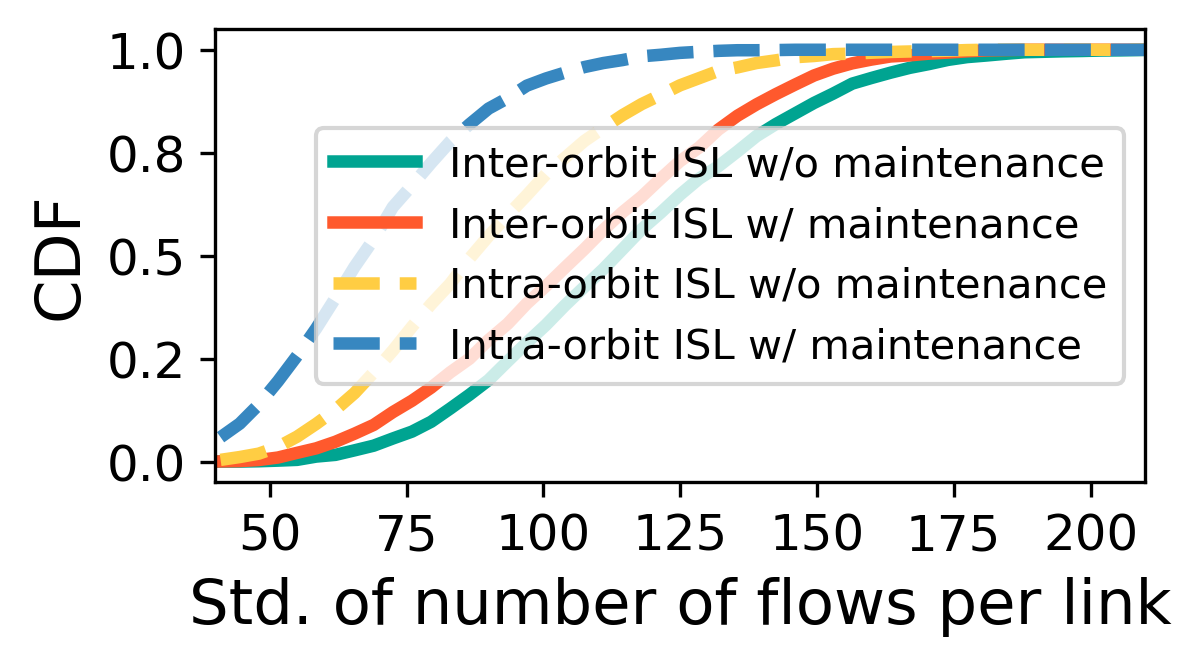

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = traffic_flow_std
ecdf = sm.distributions.ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)

plt.figure(1)
fig = plt.figure(figsize=(4,2),dpi = 300)
ax = plt.subplot(111)
plt.plot(x, y, linewidth='3', label='XX', color = "#00A491", linestyle='-')

data2 = traffic_flow_std2
ecdf = sm.distributions.ECDF(data2)
x2 = np.linspace(min(data), max(data))
y2 = ecdf(x)

plt.plot(x2, y2, linewidth='3', label='XX', color = "#FF592D", linestyle='-')

data3 = traffic_flow_std3
ecdf = sm.distributions.ECDF(data3)
x3 = np.linspace(min(data), max(data))
y3 = ecdf(x)

plt.plot(x3, y3, linewidth='3', label='XX', color = "#FFCD43", linestyle="dashed")

data4 = traffic_flow_std4
ecdf = sm.distributions.ECDF(data4)
x4 = np.linspace(min(data), max(data))
y4 = ecdf(x)

plt.plot(x4, y4, linewidth='3', label='XX', color = "#3787C0", linestyle="dashed")

plt.legend(['Inter-orbit ISL w/o maintenance','Inter-orbit ISL w/ maintenance','Intra-orbit ISL w/o maintenance','Intra-orbit ISL w/ maintenance'],loc = 'best')
#plt.legend(['4-ISL(proactive)','4-ISL(reactive)','${n}$-ISL(proactive)','${n}$-ISL(reactive)'],loc = 'best')
plt.xlabel('Std. of number of flows per link', fontsize = 15)
plt.ylabel('CDF', fontsize=15)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([40,210])
#plt.legend(loc='lower right', fontsize = 17) % 当有多个CDF曲线，对曲线进行标注

plt.savefig(r'figure17a.pdf',bbox_inches='tight',pad_inches = 0.01)

# 计算Capacity

In [9]:
folder_key = ['result','result']
strategy_key = ['gnp_1hour_decay','gp_1hour_update']

traffic_capacity_std = []
traffic_capacity_avg = []
traffic_capacity_std2 = []
traffic_capacity_avg2 = []
traffic_capacity_std3 = []
traffic_capacity_avg3 = []
traffic_capacity_std4 = []
traffic_capacity_avg4 = []
avg_list = [traffic_capacity_avg,traffic_capacity_avg2,traffic_capacity_avg3,traffic_capacity_avg4]

for flag_i in range(len(folder_key)):
    results_real = np.load('./data/%s/results_real_%s.npy'%(folder_key[flag_i],strategy_key[flag_i]),allow_pickle=True).tolist()
    traffic_flow_real = np.load('./data/%s/traffic_flow_real_%s.npy'%(folder_key[flag_i],strategy_key[flag_i]),allow_pickle=True).tolist()
    traffic_capacity = []
    for i in range(len(results_real)):
        traffic_capacity.append([])
    for i in range(len(results_real)):
        if(i % 100 == 0):print(i)
        for j in range(1000):
            #print(i,j)
            flow_max = -1e9
            path_list = results_real[i][j][4]
            for k in range(len(path_list) - 1):
                a = int(path_list[k].replace("'",''))
                b = int(path_list[k + 1].replace("'",''))
                if(a >= b):
                    key = "%s-%s"%(a,b)
                else:
                    key = "%s-%s"%(b,a)
                flow_num = traffic_flow_real[i][key]
                if(flow_num > flow_max):flow_max = flow_num
            if(flow_max != -1e9):
                traffic_capacity[i].append(10 / flow_max) 
    for t in range(cycle):
        avg_list[flag_i].append(np.average(traffic_capacity[t]))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [15]:
#decay or gnp
traffic_capacity_std = []
traffic_capacity_avg = []
for t in range(cycle):
    traffic_capacity_std.append(np.std(traffic_capacity[t]))
    traffic_capacity_avg.append(np.average(traffic_capacity[t]))

In [16]:
#update or gp
traffic_capacity_std2 = []
traffic_capacity_avg2 = []
for t in range(cycle):
    traffic_capacity_std2.append(np.std(traffic_capacity[t]))
    traffic_capacity_avg2.append(np.average(traffic_capacity[t]))

In [17]:
#decay or gnp
traffic_capacity_std3 = []
traffic_capacity_avg3 = []
for t in range(cycle):
    traffic_capacity_std3.append(np.std(traffic_capacity[t]))
    traffic_capacity_avg3.append(np.average(traffic_capacity[t]))

In [18]:
#decay or gnp
traffic_capacity_std4 = []
traffic_capacity_avg4 = []
for t in range(cycle):
    traffic_capacity_std4.append(np.std(traffic_capacity[t]))
    traffic_capacity_avg4.append(np.average(traffic_capacity[t]))

In [10]:
traffic_capacity_avg = avg_list[0]
traffic_capacity_avg2 = avg_list[1]

In [11]:
np.save('traffic_capacity_avg.npy',traffic_capacity_avg)
np.save('traffic_capacity_avg2.npy',traffic_capacity_avg2)

In [ ]:
traffic_capacity_avg = np.load('./data/traffic_capacity_avg.npy',allow_pickle=True).tolist()
traffic_capacity_avg2 = np.load('./data/traffic_capacity_avg2.npy',allow_pickle=True).tolist()

<Figure size 432x288 with 0 Axes>

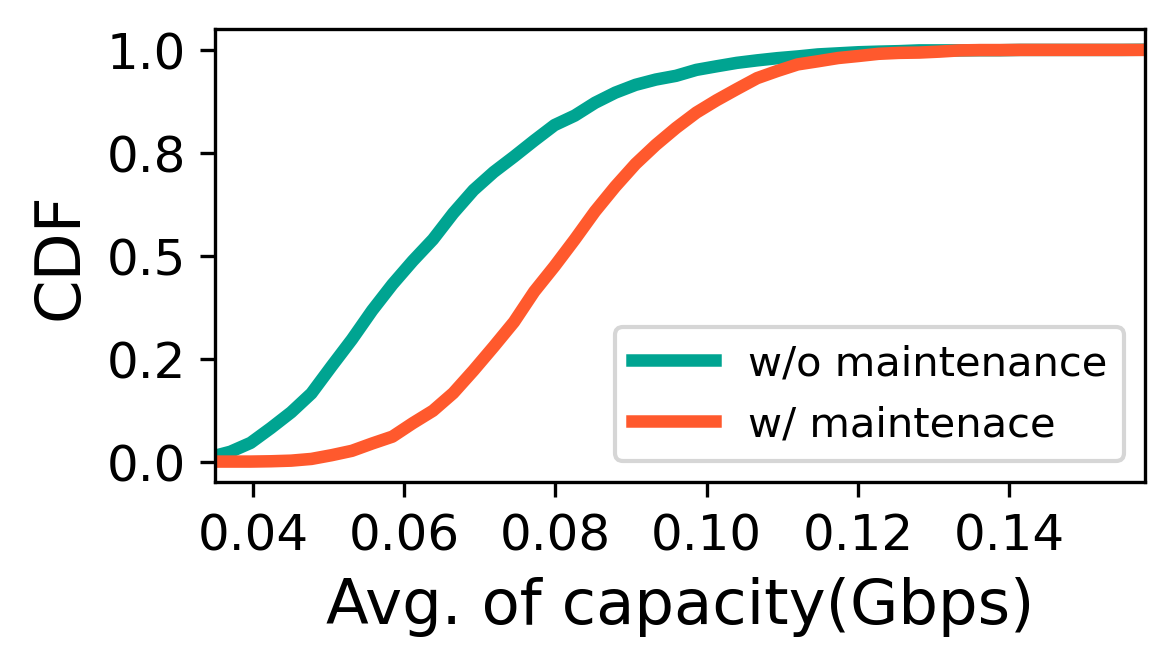

In [16]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

data = traffic_capacity_avg
ecdf = sm.distributions.ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)

plt.figure(1)
fig = plt.figure(figsize=(4,2),dpi = 300)
ax = plt.subplot(111)
plt.plot(x, y, linewidth='3', label='XX', color = "#00A491", linestyle='-')

data2 = traffic_capacity_avg2
ecdf = sm.distributions.ECDF(data2)
x2 = np.linspace(min(data), max(data))
y2 = ecdf(x)

plt.plot(x2, y2, linewidth='3', label='XX', color = "#FF592D", linestyle='-')

# data3 = traffic_capacity_avg3
# ecdf = sm.distributions.ECDF(data3)
# x3 = np.linspace(min(data), max(data))
# y3 = ecdf(x)

# plt.plot(x3, y3, linewidth='3', label='XX', color = "#FFCD43", linestyle="dashed")

# data4 = traffic_capacity_avg4
# ecdf = sm.distributions.ECDF(data4)
# x4 = np.linspace(min(data), max(data))
# y4 = ecdf(x)

# plt.plot(x4, y4, linewidth='3', label='XX', color = "#3787C0", linestyle="dashed")

#plt.legend(['Inter-orbit ISL w/o maintenance','Inter-orbit ISL w/ maintenance','Intra-orbit ISL w/o maintenance','Intra-orbit ISL w/ maintenance'],loc = 'best')
#plt.legend(['4-ISL(proactive)','4-ISL(reactive)','${n}$-ISL(proactive)','${n}$-ISL(reactive)'],loc = 'best')
plt.legend(['w/o maintenance','w/ maintenace'])
plt.xlabel('Avg. of capacity(Gbps)', fontsize = 15)
plt.ylabel('CDF', fontsize=15)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0.035,0.158])
#plt.legend(loc='lower right', fontsize = 17) % 当有多个CDF曲线，对曲线进行标注

plt.savefig(r'figure17b.pdf',bbox_inches='tight',pad_inches = 0.01)